In [1]:
# first let's make sure you have internet enabled
import requests
requests.get('http://www.google.com',timeout=10).ok

True

#### If you don't have internet access (it doesn't say "True" above)
1. make sure your account is Phone Verified in [account settings](https://www.kaggle.com/settings)
2. make sure internet is turned on in Settings -> Turn on internet

In [2]:
%%capture
# ensure we are on the latest version of kaggle-environments
!pip install --upgrade kaggle-environments

In [3]:
# Now let's set up the chess environment!
from kaggle_environments import make
env = make("chess", debug=True)

No pygame installed, ignoring import



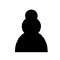
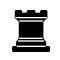
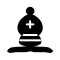
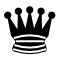
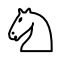
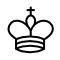
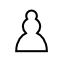
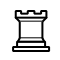
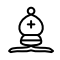
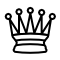
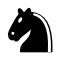
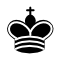

In [4]:
# this should run a game in the environment between two random bots
# NOTE: each game starts from a randomly selected opening
result = env.run(["random", "random"])
env.render(mode="ipython", width=1000, height=1000) 

### Creating your first agent
Now let's create your first agent! The environment has the [Chessnut](https://github.com/cgearhart/Chessnut) pip package installed and we'll use that to parse the board state and generate moves.

In [5]:
%%writefile main.py
import random
from collections import namedtuple, deque
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from Chessnut import Game  # Assuming the Chessnut library handles chess game logic

# Define the transition for replay buffer
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

# Neural network for approximating Q-values
def build_model(input_size, output_size):
    model = Sequential([
        Dense(32, activation='relu', input_shape=(input_size,)),  # Single hidden layer with 64 neurons
        Dense(output_size, activation='linear')  # Output layer for Q-values
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model
    
class ChessAgent:
    def __init__(self, learning_rate=0.001, discount_factor=0.9, epsilon_greedy=0.9, epsilon_min=0.1, epsilon_decay=0.99, replay_buffer_size=10000, batch_size=64):
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon_greedy
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size

        self.replay_buffer = deque(maxlen=replay_buffer_size)

        # Input size corresponds to board representation; output size corresponds to possible moves
        self.input_size = 64  # Example: board state flattened into a 64-element vector
        self.output_size = 4672  # Number of legal chess moves in UCI notation
        self.model = build_model(self.input_size, self.output_size)
        self.target_model = build_model(self.input_size, self.output_size)
        self.update_target_model()  # Sync target model with initial model

    def preprocess_board(self, board):
        """
        Convert the board (FEN or equivalent representation) to a numerical format.
        """
        mapping = {'P': 1, 'N': 2, 'B': 3, 'R': 4, 'Q': 5, 'K': 6,
                   'p': -1, 'n': -2, 'b': -3, 'r': -4, 'q': -5, 'k': -6, '.': 0}
        return np.array([mapping.get(square, 0) for square in board.split()[:64]])

    def choose_action(self, obs):
        """
        Select an action using epsilon-greedy policy.
        Includes checks for checkmates, captures, queen promotions, and illegal moves.
        """
        game = Game(obs.board)
        legal_moves = list(game.get_moves())  # Get all legal moves from the current position
        
        if not legal_moves:
            return None  # No valid moves available
    
        # Preprocess board state
        state = self.preprocess_board(obs['board']).reshape((1, 64))  # Ensure shape (1, 64)
    
        # Prioritize certain move types
        checkmate_moves = []
        capture_moves = []
        promotion_moves = []
    
        for move in legal_moves:
            # Check if move is a checkmate, capture, or promotion
            if self.is_checkmate_move(game, move):
                checkmate_moves.append(move)
            elif self.is_capture_move(move):
                capture_moves.append(move)
            elif self.is_promotion_move(move):
                promotion_moves.append(move)
    
        # Debugging: log the prioritized moves
        print(f"Checkmate moves: {checkmate_moves}")
        print(f"Capture moves: {capture_moves}")
        print(f"Promotion moves: {promotion_moves}")
    
        # Decide move priorities
        if checkmate_moves:
            chosen_move = random.choice(checkmate_moves)  # Prioritize checkmate
        elif capture_moves:
            chosen_move = random.choice(capture_moves)  # Prioritize captures
        elif promotion_moves:
            chosen_move = random.choice(promotion_moves)  # Prioritize promotions
        elif random.uniform(0, 1) < self.epsilon:
            chosen_move = random.choice(legal_moves)  # Explore: Random move
        else:
            # Exploit: Choose the best move based on Q-values
            q_values = self.model.predict(state, verbose=0)[0]
    
            # Map Q-values to legal moves
            legal_indices = [game.apply_move(move) for move in legal_moves]
            legal_q_values = [(i, q_values[i]) for i in legal_indices]
            best_move_index = max(legal_q_values, key=lambda x: x[1])[0]
    
            # Find the chosen move based on the best Q-value index
            chosen_move = legal_moves[legal_indices.index(best_move_index)]
    
        return chosen_move


    def store_transition(self, state, action, reward, next_state, done):
        """
        Store a transition in the replay buffer.
        """
        self.replay_buffer.append(Transition(state, action, reward, next_state, done))

    def train(self):
        """
        Train the model using transitions sampled from the replay buffer.
        """
        if len(self.replay_buffer) < self.batch_size:
            return

        transitions = random.sample(self.replay_buffer, self.batch_size)
        batch = Transition(*zip(*transitions))

        # Prepare data for training
        states = np.array(batch.state)
        actions = np.array(batch.action)
        rewards = np.array(batch.reward)
        next_states = np.array(batch.next_state)
        dones = np.array(batch.done)

        # Compute Q-values for current states
        q_values = self.model.predict(states, verbose=0)
        q_next_values = self.target_model.predict(next_states, verbose=0)

        # Update Q-values for actions taken
        for i in range(self.batch_size):
            target = rewards[i]
            if not dones[i]:
                target += self.gamma * np.max(q_next_values[i])
            q_values[i][actions[i]] = target

        # Train the model
        self.model.fit(states, q_values, epochs=1, verbose=0, batch_size=self.batch_size)

    def update_target_model(self):
        """
        Update the target model to match the current model.
        """
        self.target_model.set_weights(self.model.get_weights())

def chess_bot(obs):
    """
    Chess bot that makes moves based on the current observation.
    """
    agent = ChessAgent()  # Initialize the agent
    action = agent.choose_action(obs)  # Get the best action (move) from the agent
    return action


Writing main.py


### Testing your agent

Now let's see how your agent does againt the random agent!

Agent exit status/reward/time left: 
	 DONE / 0.5 / 10
	 DONE / 0.5 / 10





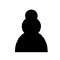
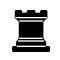
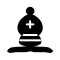
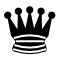
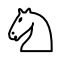
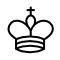
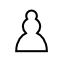
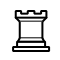
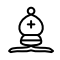
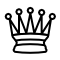
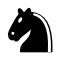
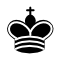

In [6]:
## result = env.run(["main.py", "random"])
print("Agent exit status/reward/time left: ")
# look at the generated replay.json and print out the agent info
for agent in result[-1]:
    print("\t", agent.status, "/", agent.reward, "/", agent.observation.remainingOverageTime)
print("\n")
# render the game
env.render(mode="ipython", width=1000, height=1000) 

# To Submit:
1. Download (or save) main.py
2. Go to the [submissions page](https://www.kaggle.com/competitions/fide-google-efficiency-chess-ai-challenge/submissions) and click "Submit Agent"
3. Upload main.py
4. Press Submit!

Now doubt you are already thinking of ways this bot could be improved! Go ahead and fork this notebook and get started! ♟️

# Submitting Multiple files 
### (or compressing your main.py)

Set up your directory structure like this:
```
kaggle_submissions/
  main.py
  <other files as desired>
```

You can run `tar -czf submission.tar.gz -C kaggle_submissions .` and upload `submission.tar.gz`